# AlexNet论文简单复现（Fashion MNIST数据集）

## 导入所需的包

In [1]:
import torch
import torch.nn as nn
from torch.utils import data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
from d2l import torch as d2l
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## 定义 Fashion MNIST 数据集和迭代器

In [2]:
def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

## torchvision官方实现（只把输出类别改成了Fashion MNIST对应的10类）

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int=1000, dropout: float=0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),                                # 改成nn.tanh会变慢吗？
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## 看一眼网络结构

In [4]:
net = AlexNet(num_classes=10, dropout=0.5).to(device)
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 定义权重初始化函数

In [5]:
def initialize(net):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.normal_(m.weight, mean=0, std=0.01)
    def init_bias(m):
        # 原文中说要把第2个、第4个和第5个卷积层的偏置置1，
        # 以加速收敛，这里复现一下，其实没什么卵用。
        
        # 经过试验，这东西不仅没什么卵用，而且还会导致训练不动！！！
        set_bias_to_one = [net.features[3],
                           net.features[8],
                           net.features[10]]
        if type(m) == nn.Conv2d:
            if m in set_bias_to_one:
                nn.init.ones_(m.bias)
            else:
                nn.init.zeros_(m.bias)
    net.apply(init_weights)
    # init_bias必须关掉！！！咱也不知道为啥
    # net.apply(init_bias)

## 定义GPU上计算损失和精度的函数

In [6]:
def evaluate_loss_acc_gpu(net, data_iter, criterion, device=device):
    """使用GPU计算模型在数据集上的精度。"""
    net.eval()  # 设置为评估模式
    loss = []
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for input, target in data_iter:
            input = input.to(device)
            target = target.to(device)
            output = net(input)
            loss.append(float(criterion(output, target).item()))
            metric.add(d2l.accuracy(output, target), target.numel())
    return sum(loss) / len(loss), metric[0] / metric[1]

## 定义AlexNet训练函数
  注意：这里优化器用的是Adam而不是SGD，因为SGD实在是太难调了！！
  
  还加了一个Reduce LR On Plateau，还原一下原文里人工降低学习率的操作。具体使用方法见[官方doc](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau)
  
  还有这个函数里用了很多动手学深度学习的库d2l的函数来画图、记录损失、记时、计算精度等等，因为实在是太好用了~事实上，这个函数就是由d2l那本书里的训练函数修改而来。

In [7]:
def train_AlexNet(net,
                  batch_size,
                  num_epochs,
                  lr,
                  weight_decay=5e-4):
    
    train_iter, valid_iter = load_data_fashion_mnist(batch_size, resize=224)
    initialize(net)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, threshold=1e-3, verbose=True)
    criterion = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc',
                                    'valid loss', 'valid acc'],
                           figsize=(7.5, 5.5))
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，范例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (input, target) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            input, target = input.to(device), target.to(device)
            output = net(input)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(loss * input.shape[0],
                           d2l.accuracy(output, target),
                           input.shape[0])
            timer.stop()
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_loss, train_acc, None, None))
        valid_loss, valid_acc = evaluate_loss_acc_gpu(
            net, valid_iter, criterion, device=device)
        scheduler.step(valid_loss)
        animator.add(epoch + 1, (None, None, valid_loss, valid_acc))
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'valid loss {valid_loss:.3f}, valid acc {valid_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

## 开搞

train loss 0.144, train acc 0.947, valid loss 0.205, valid acc 0.928
2568.6 examples/sec on cuda


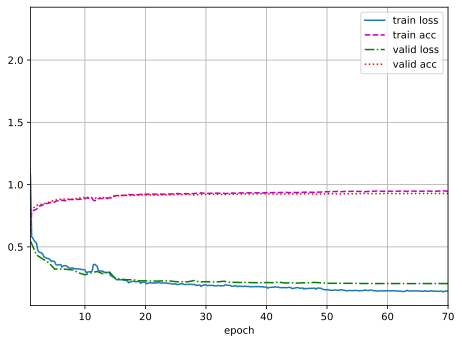

In [8]:
train_AlexNet(net,
      batch_size=256, # 爆显存的话把batch_size改小
      num_epochs=70,
      lr=0.003,
      weight_decay=5e-4)

## 保存一下模型

In [ ]:
torch.save(net, 'AlexNet.pth') # 训练好的模型我已经放在这个文件夹里了，如果要重新训练的话可以取消注释~

## 加载模型，下面要简单地复现一下原文里用最后一个隐藏层的输出来找相似图片的操作（Figure 4）
![AlexNet figure4](../pictures/Alexnet-Figure4.png)

In [10]:
net = torch.load('AlexNet.pth')

## 先用验证集把加载图片的数据集和加载数据张量的数据集、迭代器定义好

In [11]:
image_dataset = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=transforms.Resize(224), download=False)

tensor_trans = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])
tensor_dataset = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=tensor_trans, download=False)
tensor_loader = data.DataLoader(tensor_dataset, batch_size=1, shuffle=False)

## 编写两个函数，`get_hidden_output`用来获取隐层的输出，将图片编码成4096维的向量，`get_dist`用来计算两个向量之间的欧氏距离

In [12]:
def get_hidden_output(net, input):
    net.eval()
    input = input.to(device)
    output = net.features(input)
    output = net.avgpool(output)
    output = torch.flatten(output, 1)
    # 不需要用到classifier这个模块的所有层，只需要前五个就好了
    for m in net.classifier[:5]:
        output = m(output)
    return output

In [13]:
def get_dist(a, b):
    """计算行向量a和b的欧氏距离。"""
    diff = a-b
    # a可以是很多个行向量，b只有一行，对应着上面tensor_loader的batch_size=1。
    # 具体为什么a可以有很多行见下一个cell~
    return torch.sqrt(diff @ (b.T))

In [20]:
# 想要匹配的目标图片（对应着Figure4的第一列）的下标，不能超过10000
target_image_indices = [0,1,2,3,4,5]
target_tensors = []
for i in target_image_indices:
    target_tensors.append(tensor_dataset[i][0].unsqueeze(0))
# 将所有选中的图片在batch_size维度（第0维）拼接起来，做成一个batch
target_tensors = torch.concat(target_tensors, dim=0)
print(target_tensors.shape)
# 送到网络里，拿到batch里每张图片编码之后的4096维向量
target_hiddens = get_hidden_output(net, target_tensors).to(torch.float64)
print(target_hiddens.shape)

torch.Size([6, 1, 224, 224])
torch.Size([6, 4096])


In [15]:
# 把验证集里面所有图的编码之后的向量和目标图片的向量之间的欧氏距离放在一个矩阵里，行数是目标图片的数量，列数就是验证集大小。
dists_to_targets = torch.zeros((len(target_image_indices), len(tensor_dataset)))
# 计算距离，填充这个矩阵
for i, (input, _) in enumerate(tensor_loader):
    # 每次循环可以算一列，即拿着一张验证集里面的图片和所有你挑选出来的目标图片算欧氏距离，对应着`get_dist`的输出是一个列向量
    # 这里不detach()会爆显存，我花了20分钟才搞明白这一点
    dists_to_targets[:, i] = get_dist(target_hiddens, get_hidden_output(net, input).to(torch.float64)).detach().squeeze(1)

In [16]:
# 把每行自己和自己算距离的那一项屏蔽掉，因为自己和自己算距离永远都是0
for i, index in enumerate(target_image_indices):
    dists_to_targets[i, index] = 10000
# 把nan值也屏蔽掉，因为算min的时候会把nan当做最小值
dists_to_targets[torch.isnan(dists_to_targets)] = 10000

In [17]:
# Find N images most similar to the target images 
# (N must < 10, otherwise the matplotlib might not work well)
# 主要是因为matplotlib一行只能画10个子图，所以N得<=9（还得显示目标图）
N = 5

In [18]:
# `smallest_indices`中的第i个元素是和各个目标图片编码向量距离第i小的图片下标，是一个一维数组，长度和目标图片数量相等
smallest_indices = []
# 对每张目标图像分别计算N次和目标图像最接近的图，每次算完就把最接近的那张图屏蔽掉，下次就不会再找它了
for n in range(N):
    smallest_indices.append(torch.argmin(dists_to_targets, dim=1))
    for i, index in enumerate(smallest_indices[-1]):
        dists_to_targets[i, index] = 10000
print(smallest_indices)

[tensor([3410, 7376, 9573, 6433, 8832, 3103]), tensor([7702, 8522, 9499, 7273, 3332, 1487]), tensor([8504, 1701, 1557,  963,  490, 6474]), tensor([3300, 8800, 9102, 2062,  572, 3613]), tensor([8913, 2688, 7505,  312, 4917, 2840])]


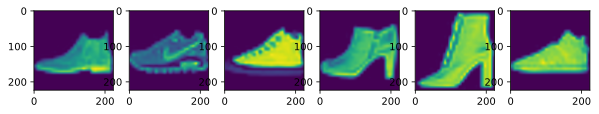

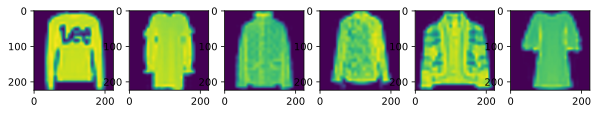

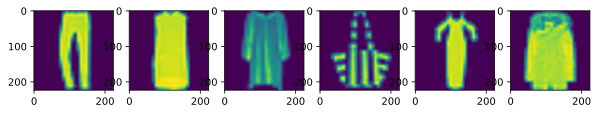

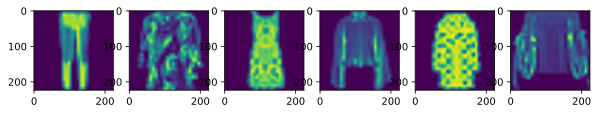

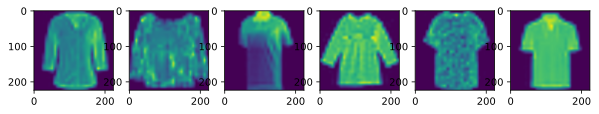

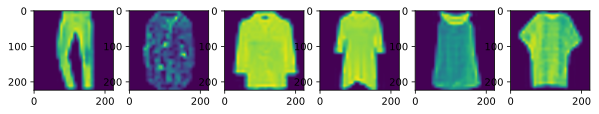

In [19]:
# 画出来，目标图像画在第一列，其余N列从左到右是经AlexNet编码之后和目标图像欧氏距离从最短到第N短的N张图
for i, target_index in enumerate(target_image_indices):
    fig = plt.figure(i+1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    figs = []
    for n in range(N+1):
        figs.append(plt.subplot(1, N+1, n+1))
        if n == 0:
            plt.imshow(image_dataset[target_index][0])
        else:
            plt.imshow(image_dataset[smallest_indices[n-1][i]][0])

# 总结一下
说实话，我入炼丹的门也才不过一年，在复现AlexNet的时候连50个epoch都等得有点不耐烦，真不知道Alex小哥一次实验等5、6天是怎么耐得住的。SGD是真的非常难调，而且我到现在也不知道为什么按照原文里说的初始化偏置值之后就训练不动了。

以我狭隘的视角和来看，这篇文章在现在最让我眼前一亮的点就是Figure4的右半张图，这个将卷积神经网络当做编码器/特征抽取器的思路，在卷积神经网络后面的发展中起到了至关重要的作用，为卷积神经网络在计算机视觉领域广泛应用开出了一条道路。

其次还有卷积神经网络卷积核可视化的操作（Figure3），在当时一度认为神经网络是黑盒模型的学术氛围下，为CNN的可解释性打下了基础。

还有个坑，就是ReLU和tanh的收敛速度没有比较，有兴趣可以自己试一下哈~

## 祝大家玩得开心~